In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("credit_analysis") \
    .getOrCreate()


bash: /home/huukhang1512/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by bash)
bash: /home/huukhang1512/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by bash)
23/05/31 21:18:36 WARN Utils: Your hostname, huukhang1512-B550I-AORUS-PRO-AX resolves to a loopback address: 127.0.1.1; using 192.168.0.162 instead (on interface wlp6s0)
23/05/31 21:18:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/31 21:18:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_original=spark.read.format("csv").option("header","true").load('./data.csv', inferSchema=True)

In [3]:
df_original.count()

855969

## We realised there's many rows that have more delimeters than the others, therefore, we decided to remove some record with wrong delimeter before hand

In [4]:
def remove_lines_with_excessive_commas(input_file, output_file):
    with open(input_file, 'r') as csv_input, open(output_file, 'w', newline='') as csv_output:
        first_line = csv_input.readline()
        csv_output.write(first_line)
        number_of_comma = first_line.count(',')
        lines_removed = 0

        for row in csv_input.readlines():
            
            if row.count(',') <= number_of_comma:
                csv_output.write(row)
            else:
                lines_removed += 1

        print(f"{lines_removed} Lines with more than {number_of_comma} commas have been removed.")

# Usage example
input_file = 'data.csv'
output_file = 'output.csv'

In [5]:
remove_lines_with_excessive_commas(input_file, output_file)

51895 Lines with more than 72 commas have been removed.


In [6]:
df=spark.read.format("csv").option("header","true").load('./output.csv', inferSchema=True)

In [7]:
df.count()

804074

In [8]:
df.show(5)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+--------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+

23/05/31 21:18:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Stage 1: Data exploration

In [9]:
df.dtypes

[('id', 'int'),
 ('member_id', 'int'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'double'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('pymnt_plan', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'double'),
 ('delinq_2yrs', 'int'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'int'),
 ('mths_since_last_delinq', 'int'),
 ('mths_since_last_record', 'int'),
 ('open_acc', 'int'),
 ('pub_rec', 'int'),
 ('revol_bal', 'int'),
 ('revol_util', 'double'),
 ('total_acc', 'int'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'double'),
 ('out_prncp_inv', 'double'),
 ('total_pymnt', 'double'),
 ('total_pymnt_inv', 'double

In [10]:
column_to_hist = [item[0] for item in df.dtypes if item[1].startswith('int') or item[1].startswith('double')]

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'member_id'}>,
        <AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt'}>,
        <AxesSubplot:title={'center':'funded_amnt_inv'}>,
        <AxesSubplot:title={'center':'int_rate'}>,
        <AxesSubplot:title={'center':'installment'}>],
       [<AxesSubplot:title={'center':'annual_inc'}>,
        <AxesSubplot:title={'center':'dti'}>,
        <AxesSubplot:title={'center':'delinq_2yrs'}>,
        <AxesSubplot:title={'center':'inq_last_6mths'}>,
        <AxesSubplot:title={'center':'mths_since_last_delinq'}>,
        <AxesSubplot:title={'center':'mths_since_last_record'}>,
        <AxesSubplot:title={'center':'open_acc'}>],
       [<AxesSubplot:title={'center':'pub_rec'}>,
        <AxesSubplot:title={'center':'revol_bal'}>,
        <AxesSubplot:title={'center':'revol_util'}>,
        <AxesSubplot:title={'center':'total_acc'}>,
        <AxesSubplot:title={'cente

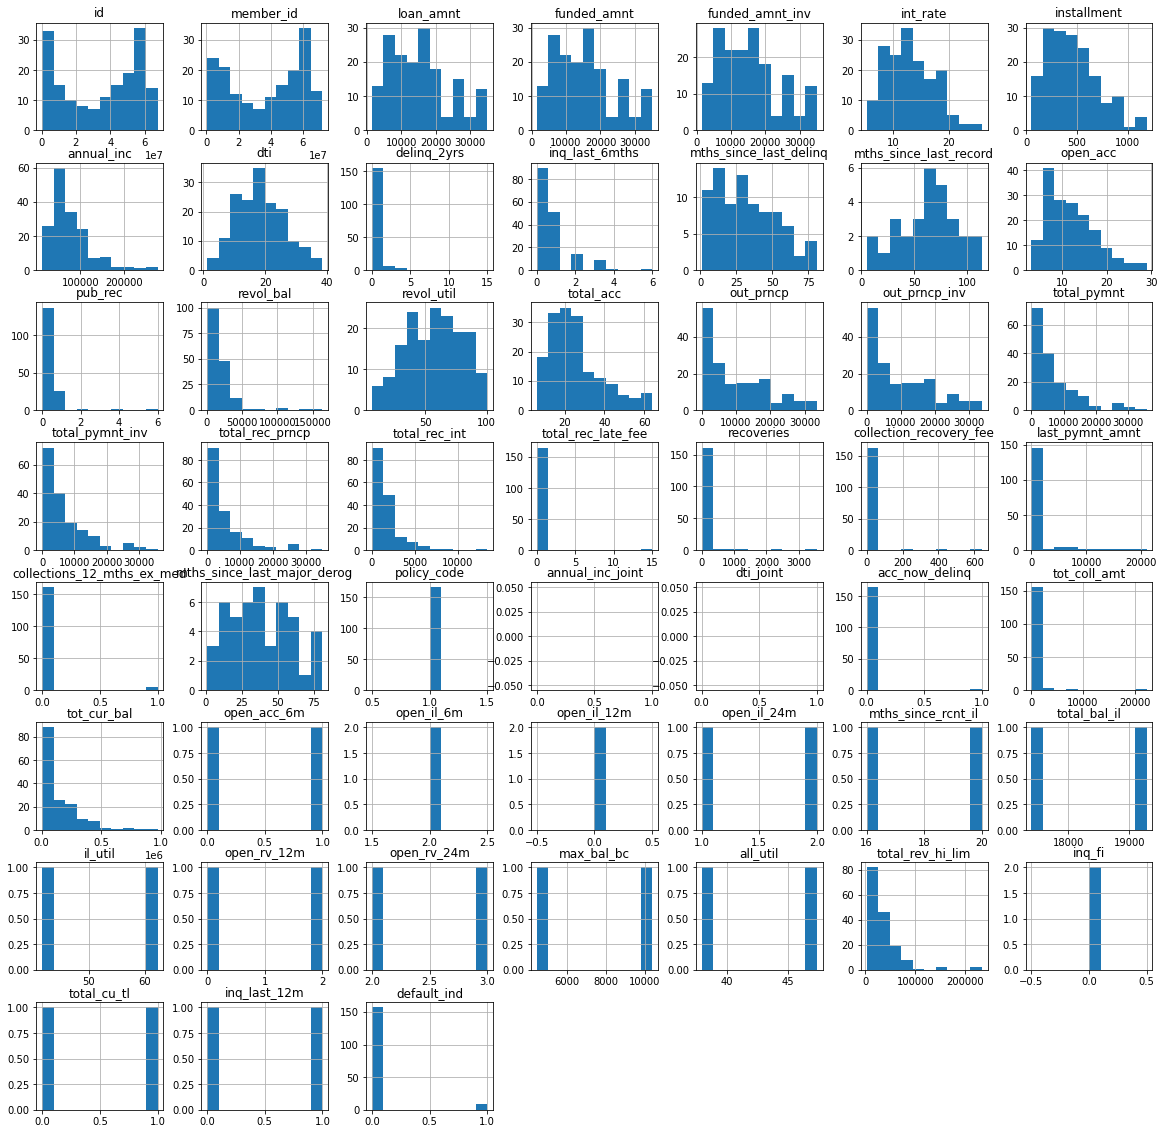

In [11]:
df.select(column_to_hist).sample(withReplacement=False, fraction=0.0002, seed=None).toPandas().hist(figsize=(20,20))

In [12]:
df.columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 '

From the domain knowledge, it is noticeable that the following fields could be removed as they do not provide great insight for the prediction, and may introduce noise and cause overfitting:

- Unique identifiers such as `id` and `member_id`
- `emp_title`, `desc`, `title` as text description of the loan won't be contribute much for the prediction
- Location identifier columns such as `zip_code` and `addr_state`, as these information do not expected to have a strong influence on loan defaults 
- Date columns such as `earliest_cr_line`, `issue_d`, `last_pymnt_d`, `next_pymnt_d`, `last_credit_pull_d` can be removed, as these data might not be relevant for the prediction model. Moreover, the model to be implemented is expected to predict the upcoming loan, and these date data might not be available.

In [13]:
df = df.drop('id', 'member_id', 'emp_title', 'desc', 'emp_title', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d')

In [14]:
df.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|  

In [15]:
len(df.columns)

61

In [16]:
df.groupBy(df["policy_code"]).count().sort("count", ascending=False).show()

+-----------+------+
|policy_code| count|
+-----------+------+
|          1|804074|
+-----------+------+



All the policy has the same policy_code. Therefore this column will be dropped

In [17]:
df = df.drop('policy_code')

In [18]:
df.groupBy(df["default_ind"]).count().show()

+-----------+------+
|default_ind| count|
+-----------+------+
|          1| 40660|
|          0|763414|
+-----------+------+



5% of the data are `default`

Visualisation of default diagram

In [19]:
df.groupby(['default_ind']).count().to_pandas_on_spark(index_col='default_ind').plot.pie(y='count')

/home/huukhang1512/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We will need to resample a training data that will have equal distribution (50/50) of default and non-default rows

In [20]:
df.groupby(['home_ownership']).count().show()


+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN| 80448|
|          RENT|320233|
|      MORTGAGE|403274|
|         OTHER|    81|
|          NONE|    35|
|           ANY|     3|
+--------------+------+



The majority of borrowers are either paying mortgage or renting a home. Around 10% of borrower actually own the house. Lastly, around 0.0148% of borrowers are in the OTHER, NONE, and ANY category. These remaining fields should be consolidate into one as 'OTHER' field.

In [21]:
df = df.replace(['NONE', 'ANY', '2 years'], 'OTHER', 'home_ownership')

In [22]:
df.select(['home_ownership']).distinct().show()

+--------------+
|home_ownership|
+--------------+
|           OWN|
|          RENT|
|      MORTGAGE|
|         OTHER|
+--------------+



In [23]:
df.groupby(['home_ownership']).count().to_pandas_on_spark(index_col='home_ownership').plot.pie(y='count')

Let's check for the default rate among all home ownership types

In [24]:
df.select(['default_ind','home_ownership']).filter(df['default_ind'] == 1).groupby(['home_ownership']).count().show()

+--------------+-----+
|home_ownership|count|
+--------------+-----+
|           OWN| 3699|
|          RENT|19203|
|      MORTGAGE|17743|
|         OTHER|   15|
+--------------+-----+



Tenants/renter seems more likely to default a loan

In [25]:
df.select(['default_ind','home_ownership']).filter(df['default_ind'] == 0).groupby(['home_ownership']).count().show()

+--------------+------+
|home_ownership| count|
+--------------+------+
|           OWN| 76749|
|          RENT|301030|
|      MORTGAGE|385531|
|         OTHER|   104|
+--------------+------+



In [26]:
df.select(['pymnt_plan']).groupby(['pymnt_plan']).count().show()

+----------+------+
|pymnt_plan| count|
+----------+------+
|         n|804071|
|         y|     3|
+----------+------+



Everything in this column is no, except for 3 yes. Therefore this column will be dropped

In [27]:
df = df.drop('pymnt_plan')

In [28]:
df.show()

+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs

In [29]:
df.select(['initial_list_status']).groupby(['initial_list_status']).count().to_pandas_on_spark(index_col='initial_list_status').plot.pie(y='count')

In [30]:
df.select('funded_amnt', 'funded_amnt_inv').show(5)

+-----------+---------------+
|funded_amnt|funded_amnt_inv|
+-----------+---------------+
|       5000|         4975.0|
|       2500|         2500.0|
|       2400|         2400.0|
|       5000|         5000.0|
|       3000|         3000.0|
+-----------+---------------+
only showing top 5 rows



In [31]:
df.select('funded_amnt', 'funded_amnt_inv').filter(df['funded_amnt'] == df['funded_amnt_inv']).count()

722842

In [32]:
df.select('funded_amnt', 'funded_amnt_inv').filter(df['funded_amnt'] > df['funded_amnt_inv']).count()

81232

In [33]:
df.select('out_prncp', 'out_prncp_inv').filter(df['out_prncp'] == df['out_prncp_inv']).count()

755007

The majority of the `funded_amnt_inv` and `out_prncp_inv` seems to be identical with the `funded_amnt` and `out_prncp` respectively. Therefore these two columns will be removed

In [34]:
df = df.drop('funded_amnt_inv', 'out_prncp_inv')

In [35]:
df.show(5)

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+--------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last

In [36]:
df.select('collections_12_mths_ex_med').groupBy('collections_12_mths_ex_med').count().show()

+--------------------------+------+
|collections_12_mths_ex_med| count|
+--------------------------+------+
|                      null|    34|
|                         1| 10159|
|                         2|   704|
|                         0|793062|
|                         3|    79|
|                         6|     2|
|                        16|     1|
|                        20|     1|
|                         4|    22|
|                         5|     7|
|                         7|     1|
|                        10|     1|
|                        14|     1|
+--------------------------+------+



The majority of the `collections_12_mths_ex_med` are 0, let's see if there's any impact of this column when its more than 0 on the `default_ind`

In [37]:
df.filter((df['collections_12_mths_ex_med'] > 0)).count()

10978

In [38]:
df.filter((df['collections_12_mths_ex_med'] > 0) & (df['default_ind'] == 1)).count()

357

=> The majority of the values when `collections_12_mths_ex_med` > 0 end up as non-default 

## Observation on `null` data fields:

In [39]:
null_dict = {col : df.filter(df[col].isNull()).count() for col in df.columns}

In [40]:
null_dict

{'loan_amnt': 0,
 'funded_amnt': 0,
 'term': 0,
 'int_rate': 0,
 'installment': 0,
 'grade': 0,
 'sub_grade': 0,
 'emp_length': 0,
 'home_ownership': 0,
 'annual_inc': 0,
 'verification_status': 0,
 'purpose': 0,
 'dti': 0,
 'delinq_2yrs': 0,
 'inq_last_6mths': 0,
 'mths_since_last_delinq': 408833,
 'mths_since_last_record': 677326,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'revol_util': 401,
 'total_acc': 0,
 'initial_list_status': 0,
 'out_prncp': 0,
 'total_pymnt': 0,
 'total_pymnt_inv': 0,
 'total_rec_prncp': 0,
 'total_rec_int': 0,
 'total_rec_late_fee': 0,
 'recoveries': 0,
 'collection_recovery_fee': 0,
 'last_pymnt_amnt': 0,
 'collections_12_mths_ex_med': 34,
 'mths_since_last_major_derog': 597237,
 'application_type': 0,
 'annual_inc_joint': 803633,
 'dti_joint': 803633,
 'verification_status_joint': 803633,
 'acc_now_delinq': 0,
 'tot_coll_amt': 45453,
 'tot_cur_bal': 45453,
 'open_acc_6m': 790893,
 'open_il_6m': 790893,
 'open_il_12m': 790893,
 'open_il_24m': 790893,


- all `*_joint` columns (`annual_inc_joint`, `dti_joint`, `verification_status_joint`) have 803633 null values, equivalent to the number of `INDIVIDUAL` `application_type` rows -> Therefore, only the `application_type` of `JOINT` will have these columns filled
- `null` value for `mths_since_last_delinq` indicate that this borrower does not have any delinquencies (does not behind on payment) record.
- `null` value for `mths_since_last_record` indicate that this borrower does not have any public record (does not have any public records of bankruptcy and judgement information)
- `null` value for `mths_since_last_major_derog` indicate that this borrower does not have any worse rating in the last 90 days


In [41]:
df.groupby(['application_type']).count().to_pandas_on_spark(index_col=['application_type']).plot.pie(y='count')

The number of data with `application_type == 'JOINT'`  are heavily underrepresent

Checking if there's any default cases when `application_type == 'JOINT'`

In [42]:
df.filter((df['application_type'] == "JOINT") & (df['default_ind'] == '1')).count()

0

Base on the dataset, virutally no `default` happened when the `application_type == 'JOINT'`!

In [43]:
df_original.filter(df_original['application_type'] == "JOINT").count()

442

We only remove 1 `"JOINT"` account from cleaning the CSV dataset

Because of high percentage of missing values in the columns related to joint application, the columns related to this will be dropped

In [44]:
df = df.drop("annual_inc_joint", "dti_joint", "verification_status_joint")

In [45]:
df.groupBy(df['verification_status']).count().show()

+-------------------+------+
|verification_status| count|
+-------------------+------+
|           Verified|259501|
|    Source Verified|304870|
|       Not Verified|239703|
+-------------------+------+



In [46]:
df.groupBy(df['verification_status'])\
    .count()\
    .to_pandas_on_spark(index_col=['verification_status'])\
    .plot.pie(y='count')

=> Evenly distributed `verfication_status` accross all accounts 

Let's see the relationship between the number of personal finance inquiries (`inq_fi`) and default rate

In [47]:
df.filter(df['inq_fi'].isNotNull() & (df['default_ind'] == 1)).count()

0

=> All the borrowers with a record of personal finance inquiries virtually not default. If this field is `null`, it indicate that the borrowers never inquiries any personal finance advice from this firm.

Because of the high volume of missing values, this column will be dropped

In [48]:
df = df.drop('inq_fi')

Next, let's see the relationship between the number of credit inquiries in the last 12 months (`inq_last_12m`) and default rate

In [49]:
df.filter(df['inq_last_12m'].isNotNull()).sort('inq_last_12m', ascending=False).show()

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+---------------------------+----------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+-----------+------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|mths_since_last_delinq|mths_since_last_record|open_acc|pub_rec|revol_bal|revol_util|total_

In [50]:
df.filter(df['inq_last_12m'].isNotNull() & (df['default_ind'] == 1)).sort('inq_last_12m', ascending=False).count()

0

In real life, higher number of number of credit inquiries will result in lower result credit, making this loan has a higher chance of default (https://www.canstar.com.au/credit-score/do-credit-checks-affect-your-credit-score/). However it is the opposite with this dataset, as more credit inquiries result in no default rate!

In [51]:
df.filter((df['inq_last_6mths'] != 0) & (df['default_ind'] == 1)).sort('inq_last_6mths', ascending=False).count()

22935

In [52]:
df.filter((df['inq_last_6mths'] != 0)).count()

348439

On the other hand, for the `inq_last_6mths` values that not 0, a portion of the data does end up as default. Therefore this column should be kept as it would be a good weight for our ML model, whilst the `inq_last_12m` will be dropped

In [53]:
df = df.drop('inq_last_12m')

For the rest of the high number of missing values columns, they will also be dropped.

In [54]:
df = df.drop('open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_cu_tl', 'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog')

In [55]:
{col : df.filter(df[col].isNull()).count() for col in df.columns}

{'loan_amnt': 0,
 'funded_amnt': 0,
 'term': 0,
 'int_rate': 0,
 'installment': 0,
 'grade': 0,
 'sub_grade': 0,
 'emp_length': 0,
 'home_ownership': 0,
 'annual_inc': 0,
 'verification_status': 0,
 'purpose': 0,
 'dti': 0,
 'delinq_2yrs': 0,
 'inq_last_6mths': 0,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'revol_util': 401,
 'total_acc': 0,
 'initial_list_status': 0,
 'out_prncp': 0,
 'total_pymnt': 0,
 'total_pymnt_inv': 0,
 'total_rec_prncp': 0,
 'total_rec_int': 0,
 'total_rec_late_fee': 0,
 'recoveries': 0,
 'collection_recovery_fee': 0,
 'last_pymnt_amnt': 0,
 'collections_12_mths_ex_med': 34,
 'application_type': 0,
 'acc_now_delinq': 0,
 'tot_coll_amt': 45453,
 'tot_cur_bal': 45453,
 'total_rev_hi_lim': 45453,
 'default_ind': 0}

### Impute the remaining null data

In [56]:
from pyspark.ml.feature import Imputer
imputer = Imputer(
    inputCols=['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med'],
    outputCols=['tot_coll_amt', 'total_rev_hi_lim', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med']
)

df = imputer.setStrategy("median").fit(df).transform(df)

In [57]:
df.show()

+---------+-----------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+----------------+--------------+------------+-----------+----------------+-----------+
|loan_amnt|funded_amnt|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|collections_12_mths_ex_med|application_type|acc_now_delinq|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|


In [58]:
df.select('emp_length').groupBy('emp_length').count().to_pandas_on_spark(index_col=['emp_length']).plot.pie(y='count')

One Hot Encoding all the categorical value

In [59]:
categorical_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]

In [60]:
categorical_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose',
 'initial_list_status',
 'application_type']

In [61]:
onehot_output_cols = list(map(lambda col : f"{col}_onehot", categorical_cols))

In [62]:
numeric_output_cols = list(map(lambda col : f"{col}_numeric", categorical_cols))

In [63]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer = StringIndexer(inputCols=categorical_cols, outputCols=numeric_output_cols)
indexer_fitted = indexer.fit(df)
df_indexed = indexer_fitted.transform(df)

one_hot = OneHotEncoder(inputCols=numeric_output_cols, outputCols=onehot_output_cols)
one_hot_df = one_hot.fit(df_indexed).transform(df_indexed)
df_one_hot = one_hot_df.drop(*numeric_output_cols, *categorical_cols)


# Stage 2: Predictive analysis 

## Process the training/testing data

### Resampling the training data with 50% default and 50% non-default

In [64]:
default_records = df_one_hot.filter(df['default_ind'] == 1).count()

In [65]:
non_default_records = df_one_hot.filter(df['default_ind'] == 0).count()

In [66]:
X = df_one_hot.sampleBy("default_ind", fractions={0: default_records/non_default_records, 1: 1}, seed=42)

In [67]:
X.filter(X['default_ind'] == 1).count()

40660

In [68]:
X.filter(X['default_ind'] == 0).count()

40928

In [69]:
X.groupBy('default_ind').count().to_pandas_on_spark(index_col='default_ind').plot.pie(y='count')

Now that our training data is well sampled, let's split the training data into 70% training and 30% testing

In [70]:
(train, test) = X.randomSplit([0.7, 0.3], seed=42)

## Process One (3 ML Models with Spark ML)

In [71]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

In [72]:
columns = df_one_hot.columns
columns.remove('default_ind')

In [73]:
vector_assembler = VectorAssembler(
    inputCols=columns,
    outputCol="features"
)

### Decision Tree

In [74]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

In [75]:
decision_tree = DecisionTreeClassifier(labelCol='default_ind', featuresCol='features')

In [76]:
pipeline = Pipeline(stages=[vector_assembler, decision_tree])

In [77]:
decision_tree_clf = pipeline.fit(train)

In [78]:
predictions = decision_tree_clf.transform(test)

In [79]:
predictions.show()

+---------+-----------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+----------+---------+---------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+--------------+------------+-----------+----------------+-----------+-------------+-------------+----------------+-----------------+---------------------+--------------------------+--------------+--------------------------+-----------------------+--------------------+---------------+--------------------+----------+
|loan_amnt|funded_amnt|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|last_pymnt_amnt|collections_12_mths_ex_med|acc_now_delinq|tot_coll_amt|tot_cur_bal|total_rev_hi_lim|default_ind|  term_oneho

In [80]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="default_ind", predictionCol="prediction", metricName="accuracy")

In [81]:
accuracy = evaluator.evaluate(predictions)

In [82]:
accuracy

0.9688467093047246

## Random Forest

In [83]:
from pyspark.ml.classification import RandomForestClassifier

In [84]:
random_forest = RandomForestClassifier(labelCol='default_ind', featuresCol='features')

In [85]:
rdn_forest_pipeline = Pipeline(stages=[vector_assembler, random_forest])

In [86]:
random_forest_tree_clf = rdn_forest_pipeline.fit(train)

In [87]:
predictions = random_forest_tree_clf.transform(test)

In [88]:
predictions.select('default_ind', 'prediction').show()

+-----------+----------+
|default_ind|prediction|
+-----------+----------+
|          1|       1.0|
|          0|       1.0|
|          0|       1.0|
|          1|       1.0|
|          1|       1.0|
|          0|       1.0|
|          1|       1.0|
|          0|       1.0|
|          1|       0.0|
|          0|       0.0|
|          0|       1.0|
|          1|       1.0|
|          0|       1.0|
|          0|       1.0|
|          0|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          1|       1.0|
|          0|       1.0|
+-----------+----------+
only showing top 20 rows



In [89]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="default_ind", predictionCol="prediction", metricName="accuracy")

In [90]:
accuracy = evaluator.evaluate(predictions)

In [91]:
accuracy

0.9518877656282236

# Feed Forward Network

In [92]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [93]:
train_df_features = vector_assembler.transform(train)
MLP = MultilayerPerceptronClassifier(layers=[train_df_features.schema["features"].metadata["ml_attr"]["num_attrs"], 4,4,2], labelCol='default_ind', featuresCol='features', seed=42)
pipeline = Pipeline(stages=[vector_assembler, MLP])

In [94]:
mlp_clf = pipeline.fit(train)

23/05/31 21:19:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/31 21:19:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [95]:
predictions = mlp_clf.transform(test)

In [96]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="default_ind", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
accuracy

0.9319166494739014

In [97]:
preds_and_labels = predictions.select(['prediction','default_ind']).withColumn('label', predictions['default_ind'].cast(FloatType())).orderBy('prediction')
preds_and_labels.show()

+----------+-----------+-----+
|prediction|default_ind|label|
+----------+-----------+-----+
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          1|  1.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
|       0.0|          0|  0.0|
+----------+-----------+-----+
only showing top 20 rows



In [98]:

preds_and_labels = preds_and_labels.select(['prediction','label'])
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

confusion_matrix = metrics.confusionMatrix()

/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [99]:
confusion_matrix.toArray()

array([[11171.,   990.],
       [  660., 11414.]])

## Process Two (3 ML Models with TensorFlow and Keras)

In [100]:
import tensorflow as tf
import pandas as pd
pd.set_option('display.max_rows', None)

2023-05-31 21:19:56.505569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 21:19:56.945200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [101]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-05-31 21:19:57.447192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 21:19:57.465530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-31 21:19:57.465670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [102]:
df_pandas = df.toPandas().sample(frac=1, random_state=42)

In [103]:
df_pandas = pd.get_dummies(data=df_pandas, columns=categorical_cols)

In [104]:
df_pandas = df_pandas.groupby('default_ind').sample(n=default_records, random_state=42)

In [105]:
df_pandas.dtypes

loan_amnt                                int32
funded_amnt                              int32
int_rate                               float64
installment                            float64
annual_inc                             float64
dti                                    float64
delinq_2yrs                              int32
inq_last_6mths                           int32
open_acc                                 int32
pub_rec                                  int32
revol_bal                                int32
revol_util                             float64
total_acc                                int32
out_prncp                              float64
total_pymnt                            float64
total_pymnt_inv                        float64
total_rec_prncp                        float64
total_rec_int                          float64
total_rec_late_fee                     float64
recoveries                             float64
collection_recovery_fee                float64
last_pymnt_am

In [106]:
uint8_cols = df_pandas.select_dtypes(include='uint8').columns.to_list()

In [107]:
df_pandas[uint8_cols] = df_pandas[uint8_cols].astype('int32')

In [108]:
split_index = int(0.7 * len(df_pandas))
(train, test) = (df_pandas[:split_index], df_pandas[split_index:])

In [109]:
import tensorflow_decision_forests as tfdf

In [110]:
X_train = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="default_ind")
X_test = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="default_ind")

### Decision Tree

In [111]:
tfdf.keras.RandomForestModel

tensorflow_decision_forests.keras.RandomForestModel

### Random Forrest

In [112]:
model = tfdf.keras.RandomForestModel()
model.fit(X_train)

Use /tmp/tmpes117bzw as temporary training directory
Reading training dataset...


2023-05-31 21:20:32.749784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_71' with dtype int32 and shape [56924]
	 [[{{node Placeholder/_71}}]]


Training dataset read in 0:00:03.788670. Found 56924 examples.
Training model...


[INFO 23-05-31 21:20:42.0518 AEST kernel.cc:1242] Loading model from path /tmp/tmpes117bzw/model/ with prefix 82ce417360444662


Model trained in 0:00:05.884123
Compiling model...


[INFO 23-05-31 21:20:42.3529 AEST decision_forest.cc:660] Model loaded with 300 root(s), 342438 node(s), and 104 input feature(s).
[INFO 23-05-31 21:20:42.3529 AEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-05-31 21:20:42.3529 AEST kernel.cc:1074] Use fast generic engine
2023-05-31 21:20:42.421912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32 and shape [56924]
	 [[{{node Placeholder/_13}}]]
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [113]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (108):
	acc_now_delinq
	annual_inc
	application_type_INDIVIDUAL
	application_type_JOINT
	collection_recovery_fee
	collections_12_mths_ex_med
	delinq_2yrs
	dti
	emp_length_10+_years
	emp_length_1_year
	emp_length_2_years
	emp_length_3_years
	emp_length_4_years
	emp_length_5_years
	emp_length_6_years
	emp_length_7_years
	emp_length_8_years
	emp_length_9_years
	emp_length_<_1_year
	emp_length_n/a
	funded_amnt
	grade_A
	grade_B
	grade_C
	grade_D
	grade_E
	grade_F
	grade_G
	home_ownership_MORTGAGE
	home_ownership_OTHER
	home_ownership_OWN
	home_ownership_RENT
	initial_list_status_f
	initial_list_status_w
	inq_last_6mths
	installment
	

In [114]:
model.compile(metrics=["accuracy"])

In [115]:
model.evaluate(X_test)

2023-05-31 21:20:43.705227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_95' with dtype int32 and shape [24396]
	 [[{{node Placeholder/_95}}]]


25/25 [==============================] - 1s 27ms/step - loss: 0.0000e+00 - accuracy: 0.9613


[0.0, 0.9612641334533691]

### Feed Forward network

In [116]:
y_train = train['default_ind']
X_train = train.drop('default_ind', axis=1)
y_test = test['default_ind']
X_test = test.drop('default_ind', axis=1)

In [117]:
X_train.shape

(56924, 108)

In [118]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(108,)))
model.add(Dense(10, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [119]:
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy'])

In [120]:
model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2)

Epoch 1/20


2023-05-31 21:20:48.168783: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe6b805c130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-31 21:20:48.168805: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2023-05-31 21:20:48.171865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-31 21:20:48.178810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:429] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-05-31 21:20:48.178845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:438] Possibly insufficient driver version: 515.65.1
2023-05-31 21:20:48.192683: E tensorflow/compiler/xla/status_macros.cc:57] INTERNAL: RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_4' defined at (most recent call last):
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 667, in start
      self.io_loop.start()
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 456, in dispatch_queue
      await self.process_one()
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 445, in process_one
      await dispatch(*args)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 352, in dispatch_shell
      await result
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 647, in execute_request
      reply_content = await reply_content
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 345, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2898, in run_cell
      result = self._run_cell(
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2944, in _run_cell
      return runner(coro)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3169, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3361, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/huukhang1512/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_163145/1158015367.py", line 1, in <module>
      model.fit(X_train, y_train, epochs=20, batch_size=100, validation_split=0.2)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/huukhang1512/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_4'
RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr 
	 [[{{node StatefulPartitionedCall_4}}]] [Op:__inference_train_function_3226]

In [ ]:
model.evaluate(X_test)